<a href="https://colab.research.google.com/github/sejeong-park/SAI_project/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%B9%B4%EB%A9%94%EB%9D%BC_%ED%92%88%EC%A7%88_%ED%96%A5%EC%83%81_%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#from google.colab import files
#files.download("/content/drive/MyDrive/dacon_camera/camera_data.zip")

In [62]:
!pip install dataloader
!pip install models
!pip install time
!pip install utils

ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [64]:
import agc
import dataloader
import models
import time
import utils

ModuleNotFoundError: ignored

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile

## 데이터 가져오기

In [3]:
root_path = '/content/drive/MyDrive/dacon_camera/'

In [4]:
train_csv = pd.read_csv(root_path + 'train.csv')
test_csv = pd.read_csv(root_path + 'test.csv')

In [5]:
train_all_input_files = root_path + 'train_input_unzip_img/'+train_csv['input_img']
train_all_label_files = root_path + 'train_label_unzip_img/'+train_csv['label_img']

이미지 옮겨 왔는지 확인 

In [6]:
train_all_input_files[0]

'/content/drive/MyDrive/dacon_camera/train_input_unzip_img/train_input_10000.png'

In [8]:
from PIL import Image

x_img=np.array(Image.open(train_all_input_files[0]))
y_img=np.array(Image.open(train_all_label_files[0]))

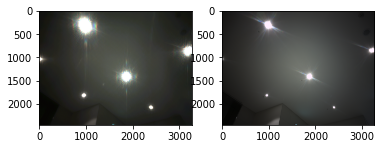

In [9]:
plt.subplot(1,2,1)
plt.imshow(x_img)
plt.subplot(1,2,2)
plt.imshow(y_img)
plt.show()

In [10]:
train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

val_input_files = train_all_input_files[:60].to_numpy()
val_label_files = train_all_label_files[:60].to_numpy()

In [11]:
len(train_all_input_files), len(train_all_label_files)

(622, 622)

In [12]:
train_all_input_files[0], train_all_label_files[0]

('/content/drive/MyDrive/dacon_camera/train_input_unzip_img/train_input_10000.png',
 '/content/drive/MyDrive/dacon_camera/train_label_unzip_img/train_label_10000.png')

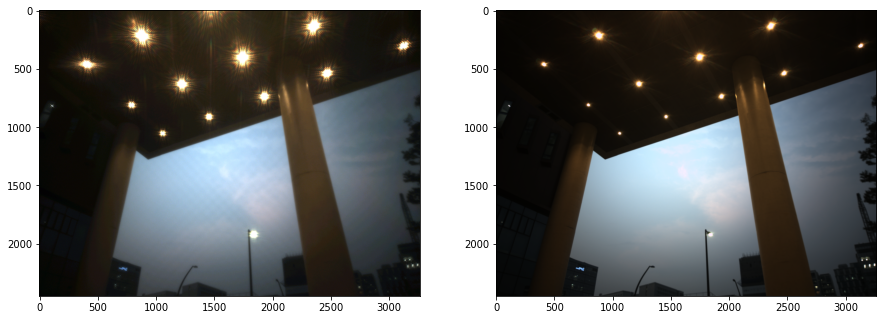

/content/drive/MyDrive/dacon_camera/train_input_unzip_img/train_input_10060.png /content/drive/MyDrive/dacon_camera/train_label_unzip_img/train_label_10060.png 



In [13]:
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break

In [21]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import concurrent.futures
import functools

In [39]:
SAVE_TRAIN_INPUT_PATH = './dacon_camera/train_input_unizp_img_'
SAVE_TRAIN_LABEL_PATH = './dacon_camera/train_label_unzip_img_'

SAVE_VAL_INPUT_PATH='./dacon_camera/val_input_img_'
SAVE_VAL_LABEL_PATH='./dacon_camera/val_label_img_'

IMG_SIZE = 256
STRIDE = 256

In [40]:
os.makedirs(f'{SAVE_TRAIN_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_TRAIN_LABEL_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_LABEL_PATH}{IMG_SIZE}', exist_ok=True)

In [41]:
def cut_img(save_path, img_path):    
    img = cv2.imread(img_path)
    img_name = os.path.basename(img_path)
    num = 0
    for top in range(0, img.shape[0], STRIDE):
        for left in range(0, img.shape[1], STRIDE):
            piece = np.zeros([IMG_SIZE, IMG_SIZE, 3], np.uint8)
            temp = img[top:top+IMG_SIZE, left:left+IMG_SIZE, :]
            piece[:temp.shape[0], :temp.shape[1], :] = temp
            cv2.imwrite(f'{save_path}{IMG_SIZE}/{num}_{img_name}', piece)            
            # np.save(f'{save_path}{img_size}/{num}.npy', piece)                
            num+=1
    return

In [42]:
train_input_files = train_all_input_files[60:]
train_label_files = train_all_label_files[60:]
#테스트용

val_input_files = train_all_input_files[:60]
val_label_files = train_all_label_files[:60]
#검증용

In [43]:
train_input_files

60     /content/drive/MyDrive/dacon_camera/train_inpu...
61     /content/drive/MyDrive/dacon_camera/train_inpu...
62     /content/drive/MyDrive/dacon_camera/train_inpu...
63     /content/drive/MyDrive/dacon_camera/train_inpu...
64     /content/drive/MyDrive/dacon_camera/train_inpu...
                             ...                        
617    /content/drive/MyDrive/dacon_camera/train_inpu...
618    /content/drive/MyDrive/dacon_camera/train_inpu...
619    /content/drive/MyDrive/dacon_camera/train_inpu...
620    /content/drive/MyDrive/dacon_camera/train_inpu...
621    /content/drive/MyDrive/dacon_camera/train_inpu...
Name: input_img, Length: 562, dtype: object

In [44]:
val_input_files

0     /content/drive/MyDrive/dacon_camera/train_inpu...
1     /content/drive/MyDrive/dacon_camera/train_inpu...
2     /content/drive/MyDrive/dacon_camera/train_inpu...
3     /content/drive/MyDrive/dacon_camera/train_inpu...
4     /content/drive/MyDrive/dacon_camera/train_inpu...
5     /content/drive/MyDrive/dacon_camera/train_inpu...
6     /content/drive/MyDrive/dacon_camera/train_inpu...
7     /content/drive/MyDrive/dacon_camera/train_inpu...
8     /content/drive/MyDrive/dacon_camera/train_inpu...
9     /content/drive/MyDrive/dacon_camera/train_inpu...
10    /content/drive/MyDrive/dacon_camera/train_inpu...
11    /content/drive/MyDrive/dacon_camera/train_inpu...
12    /content/drive/MyDrive/dacon_camera/train_inpu...
13    /content/drive/MyDrive/dacon_camera/train_inpu...
14    /content/drive/MyDrive/dacon_camera/train_inpu...
15    /content/drive/MyDrive/dacon_camera/train_inpu...
16    /content/drive/MyDrive/dacon_camera/train_inpu...
17    /content/drive/MyDrive/dacon_camera/train_

In [45]:
with concurrent.futures.ProcessPoolExecutor() as executor: # windows local 환경시 max_workers=os.cpu_count()//2
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_INPUT_PATH), train_input_files),             
        desc='train input image cut',
        total=len(train_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_LABEL_PATH), train_label_files),             
        desc='train label image cut',
        total=len(train_label_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_INPUT_PATH), val_input_files),             
        desc='val input image cut',
        total=len(val_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_LABEL_PATH), val_label_files),             
        desc='val label image cut',
        total=len(val_label_files)
    ))

In [75]:
train_inp_files = glob(f'./dacon_camera/train_input_img_256/*.npy')
train_targ_files = glob(f'./dacon_camera/train_label_img_256/*.npy')

val_inp_files = glob(f'./dacon_camera/val_input_img_256/*.npy')
val_targ_files = glob(f'./dacon_camera/val_label_img_256/*.npy')

In [76]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [78]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files), 

(0, 0, 0, 0)

data 자르기까지 성공

In [51]:
# 이미지 로드 함수
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  image = tf.cast(image, tf.float32)

  return image

In [53]:
inp_256 = load('./data/train_input_img_256/0_train_input_10060.png')
re_256 = load('./data/train_label_img_256/0_train_label_10060.png')

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

NotFoundError: ignored

In [54]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [55]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files), 

(0, 0, 0, 0)

In [13]:
BATCH_SIZE = 8
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 5
dropout_rate = 0.1

In [14]:
def cut_img(img_path_list, save_path, stride):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        img = cv2.imread(path)
        for top in range(0, img.shape[0], stride):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                np.save(f'{save_path}{img_size}/{num}.npy', piece)
                num+=1

데이터 증강 전, Test

In [ ]:
import urllib
import tensorflow.keras.datasets import layers
AUTOTUNE=tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
#데이터 증강
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break

In [ ]:
#시각화함수작성
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [ ]:
#grayscale로 data argument5
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

아래로는 data cut

In [17]:
#/content/drive/MyDrive/dacon_camera/train.csv
cut_img(train_input_files, '/content/drive/MyDrive/dacon_camera/train_input_unzip_img_', 128)
cut_img(train_label_files, './content/drive/MyDrive/dacon_camera/train_label_unzip_img_', 128)
cut_img(val_input_files, './content/drive/MyDrive/dacon_camera//val_input_img_', 128)
cut_img(val_label_files, './content/drive/MyDrive/dacon_camera/val_label_img_', 128)



  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 1/562 [00:06<1:00:25,  6.46s/it]

  0%|          | 2/562 [00:13<1:00:50,  6.52s/it]

  1%|          | 3/562 [00:20<1:03:26,  6.81s/it]

  1%|          | 4/562 [00:27<1:03:28,  6.83s/it]

  1%|          | 5/562 [00:34<1:03:42,  6.86s/it]

  1%|          | 6/562 [00:42<1:06:29,  7.18s/it]

  1%|          | 7/562 [00:49<1:05:58,  7.13s/it]

  1%|▏         | 8/562 [00:57<1:07:50,  7.35s/it]

  2%|▏         | 9/562 [01:06<1:14:01,  8.03s/it]

  2%|▏         | 10/562 [01:13<1:10:19,  7.64s/it]

  2%|▏         | 11/562 [01:20<1:08:42,  7.48s/it]

  2%|▏         | 12/562 [01:27<1:07:57,  7.41s/it]

  2%|▏         | 13/562 [01:34<1:06:35,  7.28s/it]

  2%|▏         | 14/562 [01:42<1:07:04,  7.34s/it]

  3%|▎         | 15/562 [01:49<1:06:24,  7.28s/it]

  3%|▎         | 16/562 [01:57<1:06:58,  7.36s/it]

  3%|▎         | 17/562 [02:04<1:05:58,  7.26s/it]

  3%|▎         | 18/562 [02:11<1:05:52,  7.27s/it]

  3%|▎         | 19/562 [02:18

OSError: ignored

Data Augumentation

In [ ]:
num_classes=

In [ ]:
train_inp_files = glob(f'./content/drive/MyDrive/dacon_camera/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'./content/drive/MyDrive/dacon_camera/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'./content/drive/MyDrive/dacon_camera/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'./content/drive/MyDrive/dacon_camera/val_label_img_{img_size}/*.npy')

In [ ]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [ ]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files), 

In [ ]:
def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    inp, targ = augmentation(inp, targ)
    
    return inp, targ

def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32)/255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32)/255
    return inp, targ

def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    
    return inp, targ

def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    
    return inp, targ

def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
        
    return inp, targ

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x

In [ ]:
def ResUNet101V2(input_shape=(None, None, 3), dropout_rate=0.1, start_neurons = 16):
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[122].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.models.Model(input_layer, output_layer)

    return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
model = ResUNet101V2(input_shape=(img_size, img_size, 3),dropout_rate=dropout_rate)
model.compile(loss='mae', optimizer=optimizer)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'models/baseline_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [ ]:
hist = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks_list)

In [ ]:
plt.plot(hist.history["loss"], label='train_loss')
plt.plot(hist.history["val_loss"], label='val_loss')
plt.title('loss_plot')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('models/baseline_model.h5')

In [ ]:
def predict(img_paths, stride=32, batch_size=128):
    results = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = img.astype(np.float32)/255
        crop = []
        position = []
        batch_count = 0

        result_img = np.zeros_like(img)
        voting_mask = np.zeros_like(img)

        for top in tqdm(range(0, img.shape[0], stride)):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.float32)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                crop.append(piece)
                position.append([top, left])
                batch_count += 1
                if batch_count == batch_size:
                    crop = np.array(crop)
                    pred = model(crop)*255
                    crop = []
                    batch_count = 0
                    for num, (t, l) in enumerate(position):
                        piece = pred[num]
                        h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                        result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                        voting_mask[t:t+img_size, l:l+img_size, :] += 1
                    position = []
        
        result_img = result_img/voting_mask
        result_img = result_img.astype(np.uint8)
        results.append(result_img)
        
    return results

In [ ]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score

In [ ]:
result = predict(val_input_files[:5], 32)

In [ ]:
for i, (input_path, label_path) in enumerate(zip(val_input_files[:5], val_label_files[:5])):
    input_img = cv2.imread(input_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.imread(label_path)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    pred_img = result[i]
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(input_img)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,3,2)
    plt.imshow(pred_img)
    plt.title('output_img', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(targ_img)
    plt.title('target_img', fontsize=10)
    plt.show()
    print('input PSNR :', psnr_score(input_img.astype(float), targ_img.astype(float), 255))
    print('output PSNR :', psnr_score(result[i].astype(float), targ_img.astype(float), 255), '\n')

In [ ]:
test_input_files = './data/test_input_img/'+test_csv['input_img']

In [ ]:
test_result = predict(test_input_files, 32)

In [ ]:
for i, input_path in enumerate(test_input_files):
    input_img = cv2.imread(input_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    pred_img = test_result[i]
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(input_img)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,2,2)
    plt.imshow(pred_img)
    plt.title('output_img', fontsize=10)
    plt.show()

In [ ]:


def make_submission(result):
    os.makedirs('submission', exist_ok=True)
    os.chdir("./submission/")
    sub_imgs = []
    for i, img in enumerate(result):
        path = f'test_{20000+i}.png'
        cv2.imwrite(path, img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("submission.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [ ]:
make_submission(test_result)